# Forecasting Risk of Alcohol Lapse up to Two Weeks in Advance using

Time-lagged Machine Learning Models

Kendra Wyant (Department of Psychology, University of Wisconsin-Madison)  
Gaylen E. Fronk (Department of Psychology, University of Wisconsin-Madison, Department of Psychiatry and Behavioral Sciences, Medical University of South Carolina)  
Jiachen Yu (Department of Psychology, University of Wisconsin-Madison)  
Claire E. Punturieri (Department of Psychology, University of Wisconsin-Madison)  
John J. Curtin (Department of Psychology, University of Wisconsin-Madison)  
August 20, 2025

We evaluated machine learning models predicting future alcohol lapses within 24-hour windows lagged 1 day, 3 days, 1 week, and 2 weeks. We engineered features from 4x daily ecological momentary assessment from individuals (N=151; 51% male; mean age=41; 87% non-Hispanic White) in early recovery over three months. We trained and evaluated models using nested cross-validation. Median posterior auROC was high (0.85–0.91) and slightly declined with increasing lag, though decreases were not clinically meaningful. Models performed worse for non-advantaged groups (not White, below poverty, female). Past alcohol use, abstinence self-efficacy, and craving were the most important features, with the magnitude of importance varying by lag. These findings demonstrate feasibility of predicting next-day lapses up to two weeks in advance. Embedding these models in a recovery monitoring support system could enable adaptive, personalized care. Improving model fairness and optimizing the delivery of model feedback to sustain engagement remain critical next steps.

In [ ]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(source("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true"))

path_models_lag <- format_path("risk/models/lag")
path_processed <- format_path("risk/data_processed/lag")

options(knitr.kable.NA = '')

In [ ]:
# read in tibbles for in-line code

test_metrics_all_pp_perf <- read_csv(here::here(path_models_lag, 
                                                "pp_perf_tibble.csv"), 
                                     col_types = cols())

ci_baseline <- read_csv(here::here(path_models_lag, "contrast_baseline.csv"), 
                        col_types = cols())

ci_lag <- read_csv(here::here(path_models_lag, "contrast_adjacent.csv"), 
                   col_types = cols())

pp_dem <- read_csv(here::here(path_models_lag, "pp_dem_all.csv"), col_types = cols())

pp_dem_contrast <- read_csv(here::here(path_models_lag, "pp_dem_contrast_all.csv"), col_types = cols())

screen <- read_csv(here::here(path_processed, "dem_tibble.csv"),
                   col_types = cols())

lapses_per_subid <- read_csv(here::here(path_processed, "lapse_tibble.csv"),
                             col_types = cols())

# Introduction

Alcohol and other substance use disorders (SUDs) are serious chronic conditions, characterized by high relapse rates ([McLellan et al. 2000](#ref-mclellanDrugDependenceChronic2000); [Dennis and Scott 2007](#ref-dennisManagingAddictionChronic2007)), substantial co-morbidity with other physical and mental health problems ([Substance Abuse and Mental Health Services Administration n.d.](#ref-substanceabuseandmentalhealthservicesadministration2023NSDUHDetailed); [Dennis and Scott 2007](#ref-dennisManagingAddictionChronic2007)), and an increased risk of mortality ([Hedegaard et al. 2021](#ref-hedegaardDrugOverdoseDeaths2021); [Centers for Disease Control and Prevention (CDC) n.d.](#ref-centersfordiseasecontrolandpreventioncdcAnnualAverageUnited)). Too few individuals receive medications or clinician-delivered interventions to help them initially achieve abstinence and/or reduce harms associated with their use ([Substance Abuse and Mental Health Services Administration n.d.](#ref-substanceabuseandmentalhealthservicesadministration2023NSDUHDetailed)). Moreover, this problem is even worse for subsequent continuing care during SUD recovery. Continuing care, including both risk monitoring and ongoing support, is the gold standard for managing chronic health conditions such as diabetes, asthma, and HIV ([Wagner et al. 2001](#ref-wagnerImprovingChronicIllness2001)). Yet, continuing care for SUDs is largely lacking despite ample evidence that SUDs are chronic, relapsing conditions ([Substance Abuse and Mental Health Services Administration n.d.](#ref-substanceabuseandmentalhealthservicesadministration2023NSDUHDetailed); [Stanojlović and Davidson 2021](#ref-stanojlovicTargetingBarriersSubstance2021); [Socías, Volkow, and Wood 2016](#ref-sociasAdoptingCascadeCare2016)).

An important focus of continuing care during SUD recovery is to prevent lapses (i.e., single instances of goal-inconsistent substance use) and full relapse back to harmful use ([Marlatt and Gordon 1985](#ref-marlattRelapsePreventionMaintenance1985); [Witkiewitz and Marlatt 2004](#ref-witkiewitzRelapsePreventionAlcohol2004)). Critically, the risk factors that instigate lapses during recovery are individualized, numerous, dynamic, interactive, and non-linear ([Witkiewitz and Marlatt 2007](#ref-witkiewitzModelingComplexityPosttreatment2007); [Brandon, Vidrine, and Litvin 2007](#ref-brandonRelapseRelapsePrevention2007)). The optimal supports to address these risk factors and encourage continued, successful recovery vary both across individuals and within an individual over time. Given this, continuing care could benefit greatly from a precision mental health approach that seeks to provide the right support to the right individual at the right time, every time ([Bickman, Lyon, and Wolpert 2016](#ref-bickmanAchievingPrecisionMental2016); [DeRubeis 2019](#ref-derubeisHistoryCurrentStatus2019); [Kranzler and McKay 2012](#ref-kranzlerPersonalizedTreatmentAlcohol2012)). However, such monitoring and personalized support must also be highly scalable to address the substantial unmet need for SUD continuing care.

Recent advances in both smartphone sensing ([Mohr, Zhang, and Schueller 2017](#ref-mohrPersonalSensingUnderstanding2017)) and machine learning ([Hastie, Tibshirani, and Friedman 2009](#ref-hastieElementsStatisticalLearning2009)) hold promise as a scalable foundation for monitoring and personalized support during SUD recovery. Smartphone sensing approaches (e.g., ecological momentary assessment \[EMA\], geolocation sensing) can provide the frequent, longitudinal measurement of proximal risk factors that is necessary for prediction of future lapses with high temporal precision. EMA may be particularly well-suited for lapse prediction because it can provide privileged access to the subjective experiences (e.g., craving, affect, stress, motivation, self-efficacy) that are targets for change in evidence-based approaches for relapse prevention ([Marlatt and Gordon 1985](#ref-marlattRelapsePreventionMaintenance1985); [Witkiewitz and Marlatt 2004](#ref-witkiewitzRelapsePreventionAlcohol2004); [Bowen et al. 2021](#ref-bowenMindfulnessBasedRelapsePrevention2021)). Furthermore, individuals with SUDs have found EMA to be acceptable for sustained measurement for up to a year with relatively high compliance ([Wyant et al. 2023](#ref-wyantAcceptabilityPersonalSensing2023); [Moshontz et al. 2021](#ref-moshontzProspectivePredictionLapses2021)), suggesting that this method is feasible for long-term monitoring throughout SUD recovery.

Machine learning models are well-positioned to use EMAs as inputs to provide temporally precise prediction of the probability of future lapses with sufficiently high performance to support decisions about interventions and other supports for specific individuals. These models can handle the high dimensional feature sets that may result from feature engineering densely sampled raw EMA over time ([Wyant et al. 2024](#ref-wyantMachineLearningModels2023)). They can also accommodate non-linear and interactive relationships between features and lapse probability that are likely necessary for accurate prediction of lapse probability. Moreover, rapid advances in the tools for interpretable machine learning (e.g, Shapley values ([Lundberg and Lee 2017](#ref-lundbergUnifiedApproachInterpreting2017))) now allow us to probe these models to understand which risk features contribute most strongly to a lapse prediction for a specific individual at a specific moment in time. Interventions, supports, and/or lifestyle adjustments can then be personalized to address these risks following from our understanding about relapse prevention.

Preliminary research is now emerging that uses features derived from EMAs in machine learning models to predict the probability of future alcohol use ([Soyster, Ashlock, and Fisher 2022](#ref-soysterPooledPersonspecificMachine2022); [Walters et al. 2021](#ref-waltersUsingMachineLearning2021); [Wyant et al. 2024](#ref-wyantMachineLearningModels2023)). This research is important because it rigorously required strict temporal ordering necessary for true prediction, with features measured before alcohol use outcomes. It also used resampling methods (e.g., cross-validation) that prioritize model generalizability to increase the likelihood these models will perform well with new people. And perhaps most importantly, Wyant et al. ([2024](#ref-wyantMachineLearningModels2023)) demonstrated that machine learning models using EMA can provide predictions with very high temporal precision at clinically implementable levels of performance. Specifically, they developed models that predict lapses in the immediate future (i.e., the next day and even the next hour) with area under the receiver operating characteristic curve (auROC) of 0.91 and 0.93, respectively.

Wyant et al. ([2024](#ref-wyantMachineLearningModels2023))’s next day lapse prediction model can provide personalized support recommendations to address immediate risks for possible lapses. Features derived from past EMAs can be updated in the early morning to yield the predicted lapse probability for an individual that day. Personalized supports that target the top features contributing to that prediction can be provided to assist them. For example, if predicted lapse probability is high due to recent frequent craving, they could be reminded about the benefits of urge surfing or distracting activities during brief periods when cravings arise. Conversely, guided relaxation techniques could be recommended if lapse probability was high due to recent past and anticipated stressors that day. Patients could also be assisted to implement any of these recommendations by videos or other tools within a digital therapeutic. Curtin and colleagues are currently evaluating outcomes associated with the use of this “smart” (machine learning guided) recovery monitoring and support system (RMSS) for patients with an alcohol use disorder ([Wyant et al. under review](#ref-wyantMaximizingEngagementTrustunderreview)).

Despite the promise offered by a smart RMSS based on immediate future risks (e.g., the next day), such a system has limitations. Most importantly, recommendations must be limited to previously learned skills and/or supports that are available to implement that day. However, many risks may require supports that are not available in the moment. For example, to address lifestyle imbalances, several future positive activities may need to be planned. Time with supportive friends or an AA sponsor may require time to schedule. Similarly, work or family schedules may need to be adjusted to return to attending self-help meetings. If new recovery skills or therapeutic activities are needed to address emerging risks, patients may need to book sessions with a therapist. In all these instances, patients would benefit from advanced warning about changes in their lapse probability and the associated risks that contribute to these changes. A smart RMSS could provide this advanced warning by lagging lapse probability predictions further into the future (e.g., predicting lapse probability in a 24-hour window that begins two weeks in the future). However, we do not know if such lagged models could maintain adequate performance for clinical use with individuals.

In this study, we evaluated the performance of machine learning models that predict the probability of future lapses within 24-hour prediction windows that were systematically lagged further into the future. We considered several meaningful lags for these prediction windows: 1 day, 3 days, 1 week, and 2 weeks. We conducted pre-registered analyses of both the absolute performance of these lagged models and their relative performance compared to a baseline model that predicted lapse probability in the immediate next day (i.e., no lag). In addition to the aggregate performance of these models, we also evaluated algorithmic fairness by comparing model performance across important subgroups that have documented disparities in treatment access and/or outcomes. These include comparisons by race/ethnicity ([Pinedo 2019](#ref-pinedoCurrentReexaminationRacial2019); [Kilaru et al. 2020](#ref-kilaruIncidenceTreatmentOpioid2020)), income ([Olfson et al. 2022](#ref-olfsonHealthcareCoverageService2022)), and sex at birth ([Greenfield et al. 2007](#ref-greenfieldSubstanceAbuseTreatment2007); [Kilaru et al. 2020](#ref-kilaruIncidenceTreatmentOpioid2020)). Finally, we calculated Shapley values for feature categories defined by EMA items to better understand how these models make their prediction and how these features can be used to recommend personalized supports.

# Methods

## Transparency and Openness

We adhere to research transparency principles that are crucial for robust and replicable science. We preregistered our data analytic strategy. We reported how we determined the sample size, all data exclusions, all manipulations, and all study measures. We provide a transparency report in the supplement ([Aczel et al. 2019](#ref-aczelConsensusbasedTransparencyChecklist2019)). Finally, our data, questionnaires and other study materials are publicly available on our OSF page (<https://osf.io/xta67/>), and our annotated analysis scripts and results are publicly available on our study website (<https://jjcurtin.github.io/study_lag/>).

## Participants

We recruited participants in early recovery (1-8 weeks of abstinence) from moderate to severe alcohol use disorder in Madison, Wisconsin, USA for a 3-month longitudinal study. Participants were recruited through print and targeted digital advertisements and partnerships with treatment centers. We required that participants:

1.  were age 18 or older,
2.  could write and read in English,
3.  had at least moderately severe alcohol use disorder (\>= 4 self-reported DSM-5 symptoms),
4.  were abstinent from alcohol for 1-8 weeks, and
5.  were willing to use a single smartphone (personal or study provided) while on study.

We also excluded participants exhibiting severe symptoms of psychosis or paranoia.[1]

One hundred ninety-two participants were eligible. Of these, 191 consented to participate in the study at the screening visit, and 169 subsequently enrolled in the study at the enrollment visit, which occurred approximately one week later. Fifteen participants discontinued before the first monthly follow-up visit. We excluded data from one participant who did not maintain a goal of abstinence during their participation. We also excluded data from two participants due to evidence of careless responding and unusually low compliance. Our final sample consisted of 151 participants. This sample size was determined based on traditional power analysis methods for logistic regression ([Hsieh 1989](#ref-hsiehSampleSizeTables1989)) because comparable approaches for machine learning models have not yet been validated.

## Procedure

Participants completed five study visits over approximately three months. After an initial phone screen, participants attended an in-person screening visit to determine eligibility, complete informed consent, and collect self-report measures. Eligible, consented participants returned approximately one week later for an intake visit. Three additional follow-up visits occurred about every 30 days that participants remained on study. Participants were expected to complete four daily EMAs while on study. Other personal sensing data streams (geolocation, cellular communications, sleep quality, and audio check-ins) were collected as part of the parent grant’s aims (R01 AA024391). Participants could earn up to \$150/month if they completed all study visits, had 10% or less missing EMA data, and opted in to provide data for other personal sensing data streams.

## Measures

### Ecological Momentary Assessments

Participants completed four brief (7-10 questions) EMAs daily. The first and last EMAs of the day were scheduled within one hour of participants’ typical wake and sleep times. The other two EMAs were scheduled randomly within the first and second halves of their typical day, with at least one hour between EMAs. Participants learned how to complete the EMA and the meaning of each question during their intake visit.

On all EMAs, participants reported dates and times of any previously unreported past alcohol use. Next, participants rated the maximum intensity of recent (i.e., since last EMA) experiences of craving, risky situations, stressful events, and pleasant events. Finally, participants rated their current affect on two bipolar scales: valence (Unpleasant/Unhappy to Pleasant/Happy) and arousal (Calm/Sleepy to Aroused/Alert).

On the first EMA each day, participants also rated anticipated risky situations and stressful events encountered in the next week and the likelihood that they would drink alcohol in the next week (i.e., abstinence self-efficacy).

### Individual Characteristics

We collected self-report information about demographics (age, sex at birth, race, ethnicity, education, marital status, employment, and income) and clinical characteristics (AUD milestones, number of quit attempts, lifetime AUD treatment history, lifetime receipt of AUD medication, DSM-5 AUD symptom count, current drug use ([WHO ASSIST Working Group 2002](#ref-whoassistworkinggroupAlcoholSmokingSubstance2002)), and presence of psychological symptoms ([Derogatis, L.R. 2000](#ref-derogatislBriefSymptomInventory))) to characterize our sample. DSM-5 AUD symptom count and presence of psychological symptoms were also used to determine eligibility. Demographic information was included as features in our models. A subset of these variables (sex at birth, race, ethnicity, and income) were used for model fairness analyses, as they have documented disparities in treatment access and outcomes.

As part of the aims of the parent project, we collected many other trait and state measures throughout the study. A complete list of all measures can be found on our study’s OSF page (<https://osf.io/xta67/>).

## Data Analytic Strategy

Data preprocessing, modeling, and Bayesian analyses were done in R using the tidymodels ecosystem ([Kuhn and Wickham 2020](#ref-kuhnTidymodelsCollectionPackages2020); [Kuhn 2022](#ref-kuhnTidyposteriorBayesianAnalysis2022); [Goodrich et al. 2023](#ref-goodrichRstanarmBayesianApplied2023)). Models were trained and evaluated using high-throughput computing resources provided by the University of Wisconsin Center for High Throughput Computing ([Center for High Throughput Computing 2006](#ref-chtc)).

### Predictions

A *prediction timepoint* (<a href="#fig-method" class="quarto-xref">Figure 1</a>, Panel A) is the hour at which our model calculates a predicted probability of a lapse within a future 24-hour prediction window for any specific individual. We calculated the features used to make predictions at each prediction timepoint within a feature scoring epoch that included all available EMAs up until, but not including, the prediction timepoint. The first prediction timepoint for each participant was 24 hours from midnight on their study start date. This ensured at least 24 hours of past EMAs were available in the feature scoring epoch. Subsequent prediction timepoints for each participant repeatedly rolled forward hour-by-hour until the end of their study participation.

The *prediction window* (<a href="#fig-method" class="quarto-xref">Figure 1</a>, Panel B) spans a period of time in which a lapse might occur. The prediction window width for all models was 24 hours (i.e., models predicted the probability of a lapse occurring within a specific 24-hour period). Prediction windows rolled forward hour-by-hour with the prediction timepoint. However, there were five possible *lag times* between the prediction timepoint and start of the associated prediction window. A prediction window either started immediately after the prediction time point (no lag) or was lagged by 1 day, 3 days, 1 week, or 2 weeks.

Given this structure, our models provided hour-by-hour predicted probabilities of an alcohol lapse in a future 24 hour period. Depending on the model, that future period (the prediction window) might start immediately after the prediction timepoint or up to 2 weeks into the future. For example, at midnight on the 30th day of participation, the feature scoring epoch would include the past 30 days of EMAs. Separate models would predict the probability of lapse for 24 hour periods staring at midnight that day, or similar 24 hour periods starting 1 day, 3 days, 1 week or 2 weeks after midnight on day 30.

``` python
knitr::include_graphics(path = here::here("figures/methods.png"), error = FALSE)
```

<figure id="fig-method">
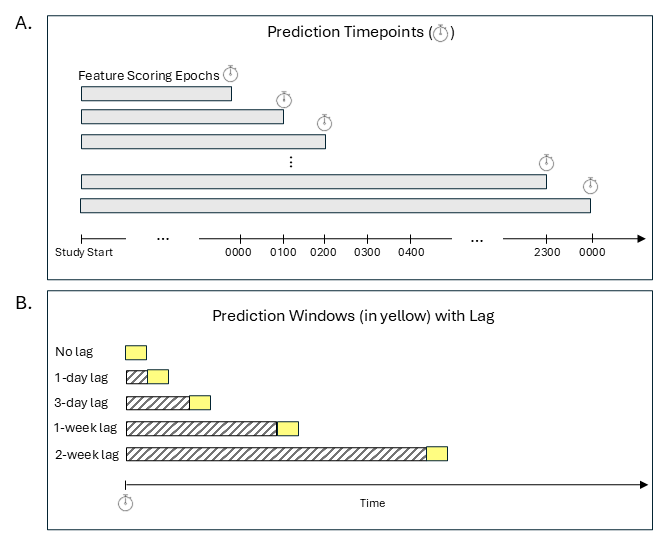
<figcaption>Figure 1: Panel A shows the prediction timepoints at which our model calculated a predicted probability of a lapse. All available data up until, but not including, the prediction timepoint was used to generate these predictions. Features were created for varying feature scoring epochs before the prediction timepoint (i.e., 12, 24, 48, 72, and 168 hours). Prediction timepoints were updated hourly. Panel B shows how the prediction window (i.e., window in which a lapse might occur) rolls forward hour-by-hour with the prediction timepoint. The prediction window width for all models was 24 hours. Additionally, there were five possible lag times between the prediction timepoint and start of the prediction window. A prediction window either started immediately after the prediction timepoint (no lag) or was lagged by 1 day, 3 days, 1 week, or 2 weeks.</figcaption>
</figure>

### Labels

The start and end date/time of past drinking episodes were reported on the first EMA item. A prediction window was labeled *lapse* if the start date/hour of any drinking episode fell within that window. A window was labeled *no lapse* if no alcohol use occurred within that window +/- 24 hours. If no alcohol use occurred within the window but did occur within 24 hours of the start or end of the window, the window was excluded. [2]

This method produced totals of: 274,179 labels for our baseline (no lag) model; 270,911 labels for our 1-day lagged model; 264,362 labels for our 3-day lagged model; 251,458 labels for our 1-week lagged model; and 228,420 labels for our 2-week lagged model.

### Feature Engineering

Features were calculated using only data collected in feature scoring epochs before each prediction timepoint to ensure our models were making true future predictions. For our no lag model the prediction timepoint was at the start of prediction window, so all data prior to the start of the prediction window was included. For our lagged models, the prediction timepoint was 1 day, 3 days, 1 week, or 2 weeks prior to the start of the prediction window, so the last EMA data used for feature engineering were collected 1 day, 3 days, 1 week, or 2 weeks prior to the start of the prediction window.

A total of 285 features were derived from three data sources:

1.  *Prediction window*: We dummy-coded features for day of the week for the start of the prediction window.

2.  *Demographics*: We created quantitative features for age (in years) and personal income (in dollars), and dummy-coded features for sex at birth (male vs. female), race/ethnicity (non-Hispanic White vs. not White), marital status (married vs. not married vs. other), education (high school or less vs. some college vs. college degree), and employment (employed vs. unemployed).

3.  *Previous EMA responses*: We created raw and change features using EMAs in varying feature scoring epochs (i.e., 12, 24, 48, 72, and 168 hours) before the prediction timepoint for all EMA items. Raw features included min, max, and median scores for each EMA item across all EMAs in each epoch for that participant. We calculated change features by subtracting each participant’s baseline mean score for each EMA item from their raw feature. These baseline mean scores were calculated using all of their EMAs collected from the start of their participation until the prediction timepoint. We also created raw and change features based on the most recent response for each EMA question and raw and change rate features from previously reported lapses and number of completed EMAs.

Other generic feature engineering steps included imputing missing data (median imputation for numeric features, mode imputation for nominal features) and removing zero and near-zero variance features as determined from held-in data (see Cross-validation section below).

### Model Training and Evaluation

#### Model Configurations

We trained and evaluated five separate classification models: one baseline (no lag) model and one model for 1-day, 3-day, 1-week, and 2-week lagged predictions. We considered four well-established statistical algorithms (elastic net, XGBoost, regularized discriminant analysis, and single layer neural networks) that vary across characteristics expected to affect model performance (e.g., flexibility, complexity, handling higher-order interactions natively) ([Kuhn and Johnson 2018](#ref-kuhnAppliedPredictiveModeling2018)).

Candidate model configurations differed across sensible values for key hyperparameters. They also differed on outcome resampling method (i.e., no resampling and up-sampling and down-sampling of the outcome using majority/no lapse to minority/lapse ratios ranging from 5:1 to 1:1).

#### Cross-validation

We used participant-grouped, nested cross-validation for model training, selection, and evaluation with auROC. auROC indexes the probability that the model will predict a higher score for a randomly selected positive case (lapse) relative to a randomly selected negative case (no lapse). Grouped cross-validation assigns all data from a participant as either held-in or held-out to avoid bias introduced when predicting a participant’s data from their own data. Folds were stratified on a between-subject variable of low vs. high lapsers (low lapsers reported fewer than 10 lapses while on study, and high lapsers reported 10 or more lapses while on study). We used 2 repeats of 5-fold cross-validation for the inner loops (i.e., *validation* sets) and 6 repeats of 5-fold cross-validation for the outer loop (i.e., *test* sets). Best model configurations were selected using median auROC across the 10 validation sets. Final performance evaluation of those best model configurations used median auROC across the 30 test sets.

#### Bayesian Model

We used a Bayesian hierarchical generalized linear model to estimate the posterior probability distributions and 95% Bayesian credible intervals (CIs) from the 30 held-out test sets for our five best models. Following recommendations from the rstanarm team and others ([RStudio Team 2020](#ref-rstudioteamRStudioIntegratedDevelopment2020); [Gabry and Goodrich 2023](#ref-gabryPriorDistributionsRstanarm2023)), we used the rstanarm default autoscaled, weakly informative, data-dependent priors that take into account the order of magnitude of the variables to provide some regularization to stabilize computation and avoid over-fitting.[3] We set two random intercepts to account for our resampling method: one for the repeat, and another for the fold nested within repeat. We specified two sets of pre-registered contrasts for model comparisons. The first set compared each lagged model to the baseline no lag model (1-day lag vs. no lag, 3-day lag vs. no lag, 1-week lag vs. no lag, 2-week lag vs. no lag). The second set compared adjacently lagged models (3-day lag vs. 1-day lag, 1-week lag vs. 3-day lag, 2-week lag vs. 1-week lag). auROCs were transformed using the logit function and regressed as a function of model contrast.

From the Bayesian model we obtained the posterior distribution (transformed back from logit) and Bayesian CIs for auROCs for all five models. To evaluate our models’ overall performance we report the median posterior probability for auROC and Bayesian CIs. This represents our best estimate for the magnitude of the auROC parameter for each model. If the CIs do not contain .5 (chance performance), this provides strong evidence (\> .95 probability) that our model is capturing signal in the data.

We then conducted Bayesian model comparisons using our two sets of contrasts - baseline and adjacent lags. For both model comparisons, we determined the probability that the models’ performances differed systematically from each other. We also report the precise posterior probability for the difference in auROCs and the 95% Bayesian CIs.

#### Fairness Analyses

Using the same 30 held-out test sets, we calculated the median posterior probability and 95% Bayesian CI for auROC for each model separately by race/ethnicity (not White vs. non-Hispanic White), income (below poverty vs. above poverty[4]), and sex at birth (female vs. male). We conducted Bayesian group comparisons to assess the likelihood that each model performs differently by group. We summarize the differences in posterior probabilities for auROC across models. Individual Bayesian fairness contrasts for all five models are available in the supplement.

### Model Characterization

To further characterize and understand our models, we used our inner resampling procedure (2 repeats of 5-fold cross validation grouped on participant and stratified by high/low lapsers) on the full data set to select a single best model configuration for each classification model (no lag, 1-day, 3-day, 1-week, and 2-week lag). The final configuration selected for each model represents the most reliable and robust configuration for deployment. We can better understand our final models by looking at the calibration of the predicted probabilities and the most important features contributing to those predictions.

#### Model Calibration

The best model configuration for each classification model was fit on the full data set. We fit this configuration using single 5-fold cross-validation. This method allowed us to obtain a single predicted probability for each observation, while still using separate data for model training and prediction. We calibrated our probabilities using Platt scaling ([Platt 1999](#ref-plattProbabilisticOutputsSupport1999)). We calculated brier scores to assess the accuracy of our raw and calibrated probabilities for the no lag and 2-week lagged models. Brier scores range from 0 (perfect accuracy) to 1 (perfect inaccuracy). A table of brier scores for all five models is available in the supplement. We provide calibration plots for the no lag and 2-week lagged models (calibration plots for all five models are available in the supplement).

#### Global Feature Importance

We used the same single 5-fold cross-validation procedure to calculate raw Shapley values for observations in our held out folds. Raw Shapley values index the importance of any feature (or set/category of features as described below) to any single prediction for a specific observation (i.e., for a specific 24 hour window for a specific participant), which indicates the “local importance” of that feature ([Lundberg and Lee 2017](#ref-lundbergUnifiedApproachInterpreting2017)). More precisely, the magnitude of the raw Shapley value for any feature indicates how much the feature score for that observation adjusted the prediction (in log-odds units) for that observation relative to the mean prediction across all observations. Positive Shapley values indicate that the feature score increased the prediction for that observation and negative values indicate that the feature score decreased the prediction.

Raw Shapley values are additive across features for an observation, with their sum across features equal to the total adjustment of the predicted value for that observation vs. the mean predicted value across all observations. This property allows raw Shapley values to be added together across features within a category to index the importance of that feature category. We created feature categories by summing raw Shapley values for all features associated with specific EMA items. In three instances, we combined features across two similar EMA items (i.e., past and anticipated risky situations, past and anticipated stressful events, and affective valence and arousal) to yield seven feature categories for distinct constructs assessed by the original 10 EMA items. Specifically, we calculated Shapley values for past use, craving, affective state, past/anticipated risky situations, past/anticipated stressful events, past pleasant events, and abstinence self-efficacy.

Shapley values can be aggregated across observations to describe the global importance of any feature (or feature category) across all predictions (i.e., for all 24-hour windows for all participants) in the dataset. Global feature importance is calculated by averaging the absolute value of the Shapley values for a feature across all observations. A large mean absolute Shapley value indicates that the feature makes big contributions to the predictions across the dataset. Global feature importance is a descriptive statistic that indicates the importance of the feature for predictions in a specific dataset, rather than a hypothetical population of observations. We provide a descriptive plot of the relative ranking of feature categories by their global feature importance for the no lag and 2-week lagged models. Global feature importance plots for all five models are available in the supplement.

# Results

## Demographic and Lapse Characteristics

<a href="#tbl-demohtml" class="quarto-xref">Table 1</a> provides a detailed breakdown of the demographic and clinical characteristics of our sample (N = 151).

``` python
footnote_table_dem_a <- "N = 151"
footnote_table_dem_b <- "*Two participants reported 100 or more quit attempts. We removed these outliers prior to calculating the mean (M), standard deviation (SD), and range."


table_dem |> 
  knitr::kable() |> 
  kable_classic() |> 
  kableExtra::group_rows(start_row = 3, end_row = 4) |> 
  kableExtra::group_rows(start_row = 6, end_row = 10) |> 
  kableExtra::group_rows(start_row = 12, end_row = 13) |> 
  kableExtra::group_rows(start_row = 15, end_row = 20) |> 
  kableExtra::group_rows(start_row = 22, end_row = 30) |> 
  kableExtra::group_rows(start_row = 33, end_row = 37) |> 
  kableExtra::group_rows("Alcohol Use Disorder Milestones", 
                         start_row = 39, end_row = 42, bold = FALSE) |> 
  kableExtra::group_rows("Lifetime History of Treatment (Can choose more than 1)", 
                         start_row = 44, end_row = 50, bold = FALSE) |> 
  kableExtra::group_rows("Received Medication for Alcohol Use Disorder", 
                         start_row = 51, end_row = 52, bold = FALSE) |> 
  kableExtra::group_rows("Current (Past 3 Month) Drug Use", 
                         start_row = 53, end_row = 60, bold = FALSE) |> 
  kableExtra::group_rows(start_row = 62, end_row = 63) |> 
  kableExtra::footnote(general = c(footnote_table_dem_a, footnote_table_dem_b), escape=FALSE)
```

|  | N | % | M | SD | Range |
|:---|---:|---:|:---|:---|:---|
| Age |  |  | 41 | 11.9 | 21-72 |
| Sex |  |  |  |  |  |
|  |  |  |  |  |  |
| Female | 74 | 49.0 |  |  |  |
| Male | 77 | 51.0 |  |  |  |
| Race |  |  |  |  |  |
|  |  |  |  |  |  |
| American Indian/Alaska Native | 3 | 2.0 |  |  |  |
| Asian | 2 | 1.3 |  |  |  |
| Black/African American | 8 | 5.3 |  |  |  |
| White/Caucasian | 131 | 86.8 |  |  |  |
| Other/Multiracial | 7 | 4.6 |  |  |  |
| Hispanic, Latino, or Spanish origin |  |  |  |  |  |
|  |  |  |  |  |  |
| Yes | 4 | 2.6 |  |  |  |
| No | 147 | 97.4 |  |  |  |
| Education |  |  |  |  |  |
|  |  |  |  |  |  |
| Less than high school or GED degree | 1 | 0.7 |  |  |  |
| High school or GED | 14 | 9.3 |  |  |  |
| Some college | 41 | 27.2 |  |  |  |
| 2-Year degree | 14 | 9.3 |  |  |  |
| College degree | 58 | 38.4 |  |  |  |
| Advanced degree | 23 | 15.2 |  |  |  |
| Employment |  |  |  |  |  |
|  |  |  |  |  |  |
| Employed full-time | 72 | 47.7 |  |  |  |
| Employed part-time | 26 | 17.2 |  |  |  |
| Full-time student | 7 | 4.6 |  |  |  |
| Homemaker | 1 | 0.7 |  |  |  |
| Disabled | 7 | 4.6 |  |  |  |
| Retired | 8 | 5.3 |  |  |  |
| Unemployed | 18 | 11.9 |  |  |  |
| Temporarily laid off, sick leave, or maternity leave | 3 | 2.0 |  |  |  |
| Other, not otherwise specified | 9 | 6.0 |  |  |  |
| Personal Income |  |  | \$34,298 | \$31,807 | \$0-200,000 |
| Marital Status |  |  |  |  |  |
|  |  |  |  |  |  |
| Never married | 67 | 44.4 |  |  |  |
| Married | 32 | 21.2 |  |  |  |
| Divorced | 45 | 29.8 |  |  |  |
| Separated | 5 | 3.3 |  |  |  |
| Widowed | 2 | 1.3 |  |  |  |
| DSM-5 Alcohol Use Disorder Symptom Count |  |  | 8.9 | 1.9 | 4-11 |
| Alcohol Use Disorder Milestones |  |  |  |  |  |
| Age of first drink |  |  | 14.6 | 2.9 | 6-24 |
| Age of regular drinking |  |  | 19.5 | 6.6 | 11-56 |
| Age at which drinking became problematic |  |  | 27.8 | 9.6 | 15-60 |
| Age of first quit attempt |  |  | 31.5 | 10.4 | 15-65 |
| Number of Quit Attempts\* |  |  | 5.5 | 5.8 | 0-30 |
| Lifetime History of Treatment (Can choose more than 1) |  |  |  |  |  |
| Long-term residential (6+ months) | 8 | 5.3 |  |  |  |
| Short-term residential (\< 6 months) | 49 | 32.5 |  |  |  |
| Outpatient | 74 | 49.0 |  |  |  |
| Individual counseling | 97 | 64.2 |  |  |  |
| Group counseling | 62 | 41.1 |  |  |  |
| Alcoholics Anonymous/Narcotics Anonymous | 93 | 61.6 |  |  |  |
| Other | 40 | 26.5 |  |  |  |
| Received Medication for Alcohol Use Disorder |  |  |  |  |  |
| Yes | 59 | 39.1 |  |  |  |
| No | 92 | 60.9 |  |  |  |
| Current (Past 3 Month) Drug Use |  |  |  |  |  |
| Tobacco products (cigarettes, chewing tobacco, cigars, etc.) | 84 | 55.6 |  |  |  |
| Cannabis (marijuana, pot, grass, hash, etc.) | 66 | 43.7 |  |  |  |
| Cocaine (coke, crack, etc.) | 18 | 11.9 |  |  |  |
| Amphetamine type stimulants (speed, diet pills, ecstasy, etc.) | 15 | 9.9 |  |  |  |
| Inhalants (nitrous, glue, petrol, paint thinner, etc.) | 3 | 2.0 |  |  |  |
| Sedatives or sleeping pills (Valium, Serepax, Rohypnol, etc.) | 22 | 14.6 |  |  |  |
| Hallucinogens (LSD, acid, mushrooms, PCP, Special K, etc.) | 14 | 9.3 |  |  |  |
| Opioids (heroin, morphine, methadone, codeine, etc.) | 16 | 10.6 |  |  |  |
| Reported 1 or More Lapse During Study Period |  |  |  |  |  |
|  |  |  |  |  |  |
| Yes | 84 | 55.6 |  |  |  |
| No | 67 | 44.4 |  |  |  |
| Number of reported lapses |  |  | 6.8 | 12 | 0-75 |
| <span style="font-style: italic;">Note: </span> |  |  |  |  |  |
|  N = 151 |  |  |  |  |  |
|  \*Two participants reported 100 or more quit attempts. We removed these outliers prior to calculating the mean (M), standard deviation (SD), and range. |  |  |  |  |  |

Table 1: Demographic and Clinical Characteristics

## Model Evaluation

<a href="#fig-pp" class="quarto-xref">Figure 2</a> presents the full posterior probability distributions for auROC for each model (no lag, 1-day, 3-day, 1-week, and 2-week lag). The median auROCs from these posterior distributions were 0.91 (no lag), 0.89 (1-day lag), 0.88 (3-day lag), 0.87 (1-week lag), and 0.85 (2-week lag). These values represent our best estimates for the magnitude of the auROC parameter for each model. The 95% Bayesian CI for the auROCs for these models were relatively narrow and did not contain 0.5: no lag \[0.90-0.92\], 1-day lag \[0.88-0.91\], 3-day lag \[0.87-0.90\], 1-week lag \[0.85-0.89\], 2-week lag \[0.83-0.87\].

``` python
pp_tidy |> 
  mutate(model = factor(model, levels = c("lag0", "lag24", "lag72", "lag168", "lag336"),
                        labels = c("No lag", "1-day", "3-day", "1-week", "2-week"))) |>
  ggplot() + 
  geom_histogram(aes(x = posterior), fill = "light grey", color = "black", linewidth = .5,  
                 bins = 60) +
  geom_segment(mapping = aes(y = 3400, yend = 3800, x = pp_median, xend = pp_median),
               linewidth = .5, data = ci) +
  geom_segment(mapping = aes(y = 3600, yend = 3600, x = pp_lower, xend = pp_upper),
                linewidth = .5, data = ci) +
  facet_wrap(~model, ncol = 1) +
  geom_vline(xintercept = .5, linewidth = .5, linetype = "dashed") +
  scale_y_continuous("Posterior Samples") +
  xlab("Area Under ROC Curve") +
  expand_limits(x = c(.5, 1)) +
  theme_classic() 
```

<figure id="fig-pp">
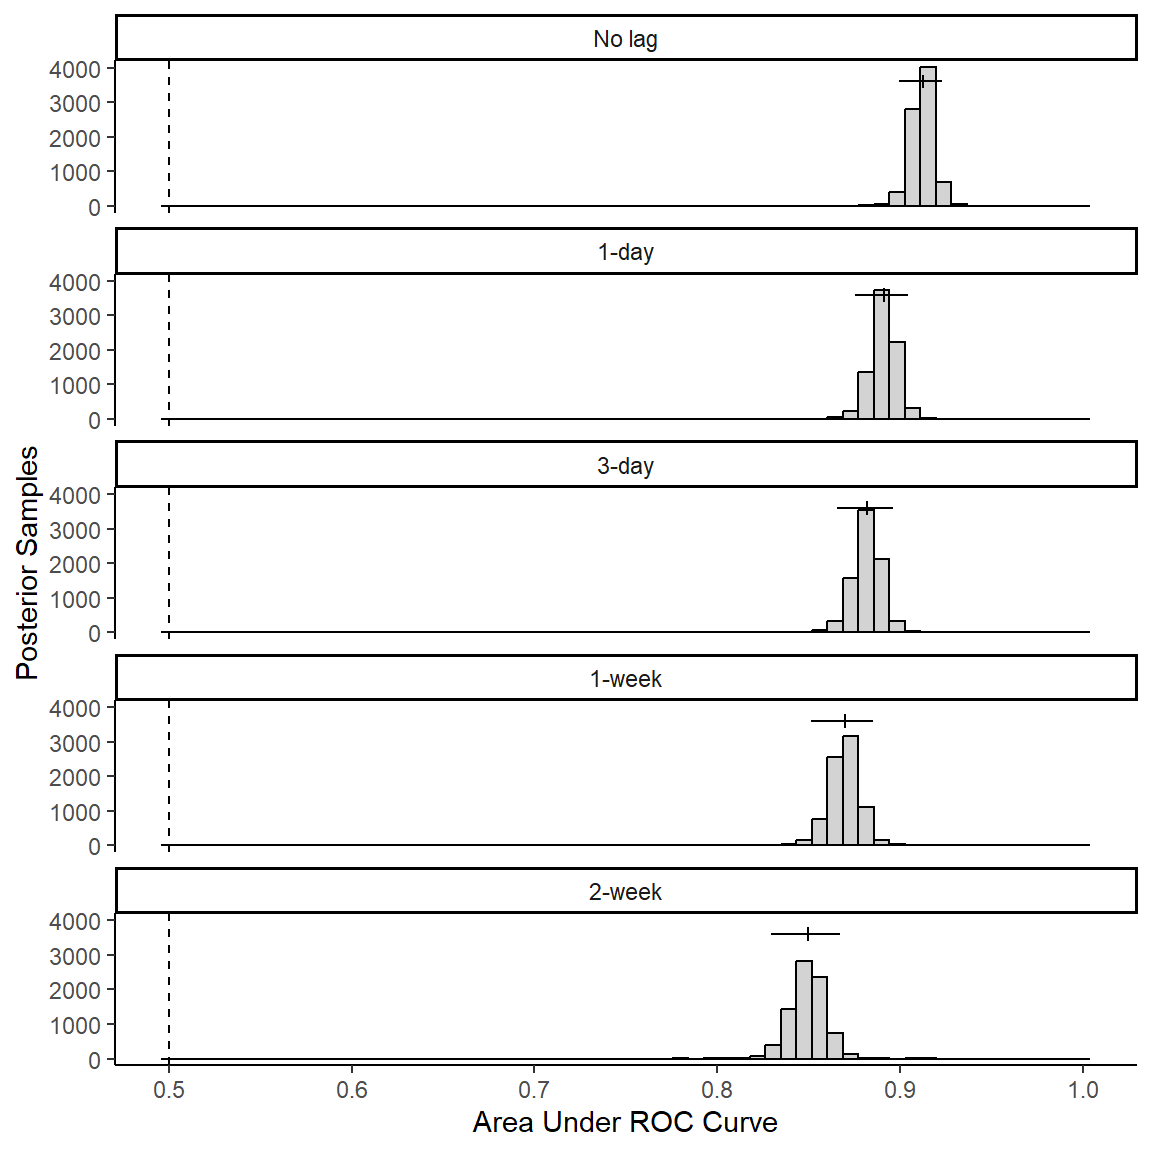
<figcaption>Figure 2: Posterior probability distributions for area under ROC curve (auROC) for each model (no lag, 1-day, 3-day, 1-week, and 2-week lag). Each distribution reflects 8,000 posterior samples (4 chains × 2,000 samples) from a Bayesian hierarchical generalized linear model. Horizonatal lines depict 95% Bayesian credible intervals (CI) and vertical solid lines depict median posterior probability for auROC. Vertical dashed line represents expected performance from a random classifier (.5 auROC).</figcaption>
</figure>

## Model Comparisons

<a href="#tbl-model" class="quarto-xref">Table 2</a> presents the median difference in auROC, 95% Bayesian CI, and posterior probability that that the auROC difference was greater than 0 for all baseline and adjacent lag contrasts. Median auROC differences less than 0 indicate the more lagged model, on average, performed worse than the more immediate model (e.g., 1-day lag - no lag, 3-day lag - 1-day lag). There was strong evidence (probabilities = 1) that the lagged models performed worse than the baseline (no lag) model, with average drops in auROC ranging from 0.02-0.06, and the previous adjacent lagged model, with average drops in auROC ranging from 0.01-0.02.

``` python
footnote_table_model <- "Median auROC differences less than 0 indicate the more lagged model, on average, performed worse than the more immediate model (e.g., 1-day lag - no lag, 3-day lag - 1-day lag). Bayesian CI represents the range of values where there is a 95% probability that the true auROC difference lies within that range. Probability indicates the posterior probability that this difference is greater than 0 (i.e., the models are performing differently)."

table_ci |> 
  knitr::kable() |> 
  kable_classic() |> 
  kableExtra::column_spec(1, width = "25em") |> 
  kableExtra::group_rows(start_row = 2, end_row = 5) |> 
  kableExtra::group_rows(start_row = 7, end_row = 9) |> 
  kableExtra::row_spec(5, extra_css = "border-bottom: 1px solid") |> 
  kableExtra::add_footnote(label = footnote_table_model,
                           notation = "none",
                           escape = FALSE)
```

| Contrast | Median | Bayesian CI | Probability |
|:---|:---|:---|:---|
| Baseline Contrasts |  |  |  |
|  |  |  |  |
| 1 day vs. No lag | -0.021 | \[-0.026, -0.017\] | 0 |
| 3 days vs. No lag | -0.03 | \[-0.035, -0.025\] | 0 |
| 1 week vs. No lag | -0.043 | \[-0.049, -0.037\] | 0 |
| 2 weeks vs. No lag | -0.063 | \[-0.07, -0.056\] | 0 |
| Adjacent Contrasts |  |  |  |
|  |  |  |  |
| 3 days vs. 1 day | -0.009 | \[-0.014, -0.005\] | 0 |
| 1 week vs. 3 days | -0.012 | \[-0.017, -0.008\] | 0 |
| 2 weeks vs. 1 week | -0.02 | \[-0.026, -0.015\] | 0 |
|  Median auROC differences less than 0 indicate the more lagged model, on average, performed worse than the more immediate model (e.g., 1-day lag - no lag, 3-day lag - 1-day lag). Bayesian CI represents the range of values where there is a 95% probability that the true auROC difference lies within that range. Probability indicates the posterior probability that this difference is greater than 0 (i.e., the models are performing differently). |  |  |  |

Table 2: Median difference in auROC, 95% Bayesian credible interval (CI), and posterior probability that that the auROC difference was greater than 0 for all baseline and adjacent lag contrasts.

## Fairness Analyses

<a href="#tbl-fairness" class="quarto-xref">Table 3</a> presents the median difference in auROC, 95% Bayesian CI, and posterior probability that the auROC difference was greater than 0 for the three fairness contrasts: race/ethnicity (not White; *N* = 20 vs. Non-Hispanic White; *N* = 131), sex at birth (female; *N* = 74 vs. male; *N* = 77), and income (below poverty; *N* = 49 vs. above poverty; *N* = 102). Median auROC differences less than 0 indicate the model, on average, performed worse for the non-advantaged group (female, not White, below poverty) compared to the advantaged group (male, non-Hispanic White, and above poverty). In <a href="#tbl-fairness" class="quarto-xref">Table 3</a> we present fairness analyses for our baseline model (no lag) and for our longest lagged model (2-week lag), as this is likely the most clinically useful lagged model for providing advanced warning of lapse risk. Fairness analyses for all five models are available in the supplement.

There was strong evidence (probabilities \> .84) that our models performed worse for the non-advantaged groups compared to the advantaged groups. On average, across all five models, there was a median decrease in auROC of 0.13 (range 0.13-0.17) for participants who were not White compared to non-Hispanic White participants. On average, across all five models, there was a median decrease in auROC of 0.05 (range 0.04-0.10) for female participants compared to male participants. On average, across all five models, there was a median decrease in auROC of 0.02 (range 0.01-0.04) for participants below the federal poverty line compared to participants above the federal poverty line.

The proportion of positive lapse labels over all labels (lapse and no lapse) for each demographic subgroup were relatively consistent across groups: race/ethnicity (6%, not White vs. 8%, non-Hispanic White), income (12%, below poverty vs. 7%, above poverty), sex at birth (9%, female vs. 7%, male).

``` python
footnote_table_fair <- "Median auROC differences less than 0 indicate the model, on average, performed worse for the disadvantaged group (female, not White, income below poverty) compared to the advantaged group (male, non-Hispanic White, income above poverty). Bayesian CI represents the range of values where there is a 95% probability that the true auROC difference lies within that range. Probability indicates the posterior probability that this difference is greater than 0 (i.e., the models are performing differently for fairness subgroups)."

table_ci_fair |> 
  knitr::kable() |> 
  kable_classic() |> 
  kableExtra::column_spec(1, width = "25em") |> 
  kableExtra::group_rows(start_row = 2, end_row = 4) |> 
  kableExtra::group_rows(start_row = 6, end_row = 8) |> 
  kableExtra::row_spec(4, extra_css = "border-bottom: 1px solid")  |> 
  kableExtra::add_footnote(label = footnote_table_fair,
                           notation = "none",
                           escape = FALSE)
```

| Contrast | Median | Bayesian CI | Probability |
|:---|:---|:---|:---|
| Fairness Contrasts (No Lag) |  |  |  |
|  |  |  |  |
| female vs. male | -0.043 | \[-0.059, -0.028\] | 0 |
| not White vs. non-Hispanic White | -0.131 | \[-0.222, -0.057\] | 0.002 |
| below poverty vs. above poverty | -0.012 | \[-0.033, 0.007\] | 0.152 |
| Fairness Contrasts (2-week Lag) |  |  |  |
|  |  |  |  |
| female vs. male | -0.098 | \[-0.125, -0.073\] | 0 |
| not White vs. non-Hispanic White | -0.13 | \[-0.208, -0.058\] | 0.002 |
| below poverty vs. above poverty | -0.039 | \[-0.073, -0.008\] | 0.02 |
|  Median auROC differences less than 0 indicate the model, on average, performed worse for the disadvantaged group (female, not White, income below poverty) compared to the advantaged group (male, non-Hispanic White, income above poverty). Bayesian CI represents the range of values where there is a 95% probability that the true auROC difference lies within that range. Probability indicates the posterior probability that this difference is greater than 0 (i.e., the models are performing differently for fairness subgroups). |  |  |  |

Table 3: Median difference in auROC, 95% Bayesian credible interval (CI), and posterior probability that that the auROC difference was greater than 0 for fairness contrasts for the no lag and 2-week lagged models.

## Model Calibration

The raw probabilities produced by our final models were not well calibrated. Consequently, we used Platt scaling to improve calibration. Platt scaling showed excellent improvement to the no lag model with a brier score of .043. Calibration also improved probability accuracy for the 2-week lagged model with a brier score .063. For comparison, raw probability scores yielded brier scores of .071 and .077 for the no lag and 2-week lagged models, respectively.

<a href="#fig-cal" class="quarto-xref">Figure 3</a> shows the calibration plots for the raw and calibrated probabilities for the no lag and 2-week lagged model. It also includes a histogram of raw probabilities that demonstrates our models produced variable predicted probabilities, spanning nearly the entire 0 - 1 range. Calibration plots and brier scores for all 5 models are available in the supplement.

``` python
preds_all |> 
  mutate(prob = factor(prob, levels = c("Raw (uncalibrated)", 
                                        "Platt calibration"))) |> 
  group_by(bins, model, prob)  |> 
  summarize(mean_lapse = mean(lapse), .groups = "drop") |> 
  mutate(
    bins = as.numeric(bins),
    midpoints = bin_width/2 + bin_width * (bins - 1)
  )  |> 
  ggplot(aes(x = midpoints, y = mean_lapse, group = prob,
             color = prob, linetype = prob)) +
  geom_abline(slope = 1, intercept = 0, linetype = "longdash", color = "gray80") +
  geom_line(linewidth = .7) +
  geom_rect(data = mini_hist, inherit.aes = FALSE,
            aes(xmin = x - bin_width / 2,
                xmax = x + bin_width / 2,
                ymin = -y,
                ymax = 0),
            alpha = .4) +
  facet_wrap(~ model, ncol = 2) +
  labs(
    x = "Predicted Lapse Probability (Bin Midpoint)",
    y = "Observed Lapse Probability",
    color = NULL,
    linetype = NULL
  ) +
  scale_x_continuous(breaks = seq(0, 1, bin_width), limits = c(0, 1)) +
  scale_y_continuous(limits = c(-0.08, 1), breaks = seq(0,1, bin_width),
                     expand = c(0, 0)) +
  coord_cartesian(clip = "off") +
  scale_color_manual(values = c("black", "#cb6bce")) +
  scale_linetype_manual(values = c("solid", "twodash")) +
  theme_classic(base_size = 11) +
  theme(
    legend.position = "bottom",
    strip.text = element_text(size = 11),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(size = 10),
    axis.text = element_text(size = 10),
    axis.title = element_text(face = "bold")
  )
```

<figure id="fig-cal">
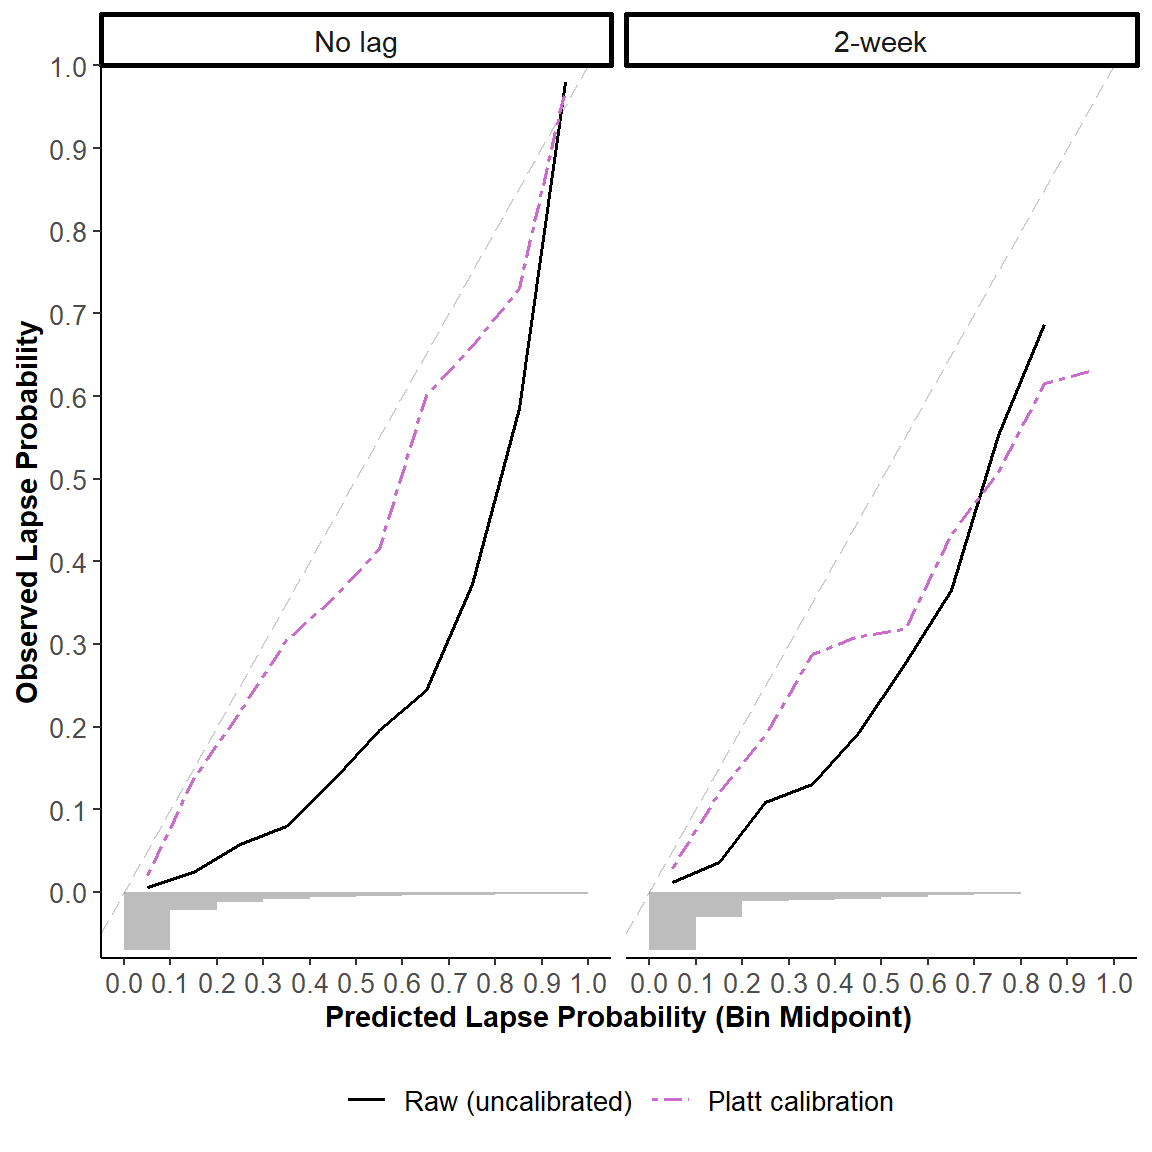
<figcaption>Figure 3: Calibration plots of raw and calibrated lapse probabilities for the baseline (no lag) and 2-week lagged models. Predicted probabilities (x-axis) are binned into deciles. Observed lapse probability (y-axis) represents the proportion of actual lapses observed in each bin. The dashed diagonal represents perfect calibration. Points below the line indicate overestimation and points above the line indicate underestimation. Raw probabilities are depicted as solid black curves. Platt calibrated probabilites are depicted as pink dashed curves. The grey histogram along the bottom of the plot represents the proportion of raw probabilities in each bin.</figcaption>
</figure>

## Feature Importance

Global feature importance is an indicator of how important a feature category was to the model’s predictions, on average (i.e., across all participants and all observations). The top globally important feature category (i.e., highest mean \|Shapley value\|) for all models was past use. Future efficacy was a strong predictor for more immediate model predictions (i.e., no lag), but its importance diminished as lag time increased. On the other hand, as lag time increased past/future risky situations increased in importance. Craving was consistently important, in magnitude, across all models. <a href="#fig-4" class="quarto-xref">Figure 4</a> shows the relative ranking of feature categories for the no lag and 2-week lagged models. A plot of global feature importance for each feature category as a function of lag time is available in the supplement. These findings were also consistent across demographic subgroups (plots of global feature importance by demographic group are available for the no lag and 2-week lagged models in the supplement).

``` python
global_panel 
```

<figure id="fig-4">
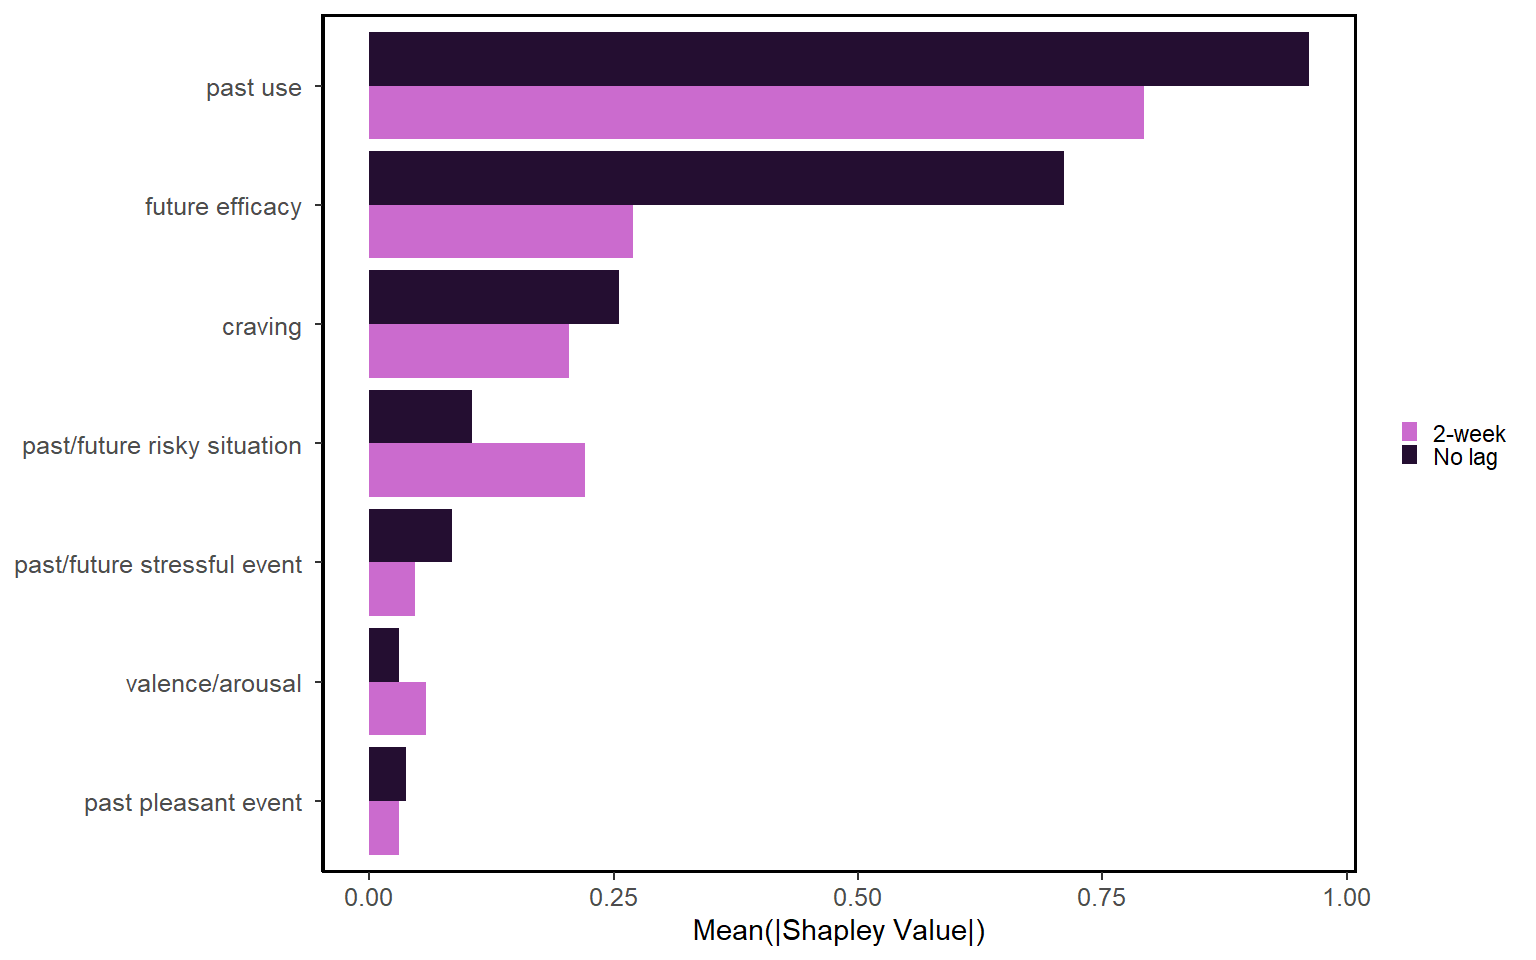
<figcaption>Figure 4: Global feature importance (mean |Shapley value|) for feature categories for the no lag and 2-week lagged models. Feature categories are ordered by their aggregate global importance. The importance of each feature category for each model is displayed separately by color.</figcaption>
</figure>

# Discussion

All the models that we evaluated performed exceptionally well. The no lag model had a .91 median posterior probability for auROC. This model predicts the probability of an immediate (i.e., within 24 hours) lapse back to alcohol use. Our 2-week lagged model, which made the most distal predictions, had a .85 median posterior probability for auROC, suggesting lagged models can be used to shift a 24-hour prediction window meaningfully into the future.

Across models (no lag, 1 day, 3 days, 1 week, and 2 weeks), model performance systematically decreased as models predicted further into the future. All lagged models had lower performance compared to the no lag baseline model and to the preceding adjacent lag model. This is unsurprising given what we know about prediction and substance use. Many important relapse risk factors are fluctuating processes that can first emerge and/or change day-by-day, if not more frequently. As lag time increases, features become less proximal to the start of the prediction window. Still, we wish to emphasize that our lowest auROC (.85) is still quite good, and the benefit of advanced notice (i.e., 2 weeks) likely outweighs the modest cost to model performance.

Collectively, these results suggest we can achieve clinically meaningful performance up to two weeks out. Our rigorous resampling methods (grouped, nested, k-fold cross-validation) make us confident that these are valid estimates of how our models would perform with new individuals. Furthermore, it should noted that both the no lag and 2-week lagged models can be combined in a complementary fashion that allows both for highly accurate immediate lapse prediction and advanced warning about future lapse risk.

## Model Fairness

In recent years, the machine learning field has begun to recognize the need to evaluate model fairness when algorithms are used to inform important decisions (e.g., healthcare services offered, eligibility for loans, early parole). Algorithms that perform favorably for only majority group members may exacerbate existing disparities in access to resources and important clinical outcomes ([Veinot, Mitchell, and Ancker 2018](#ref-veinotGoodIntentionsAre2018)). In this study, we assessed model fairness by comparing model performance across important subgroups with known disparities in substance use treatment access and/or outcomes - race/ethnicity (not White vs. non-Hispanic White), income (below poverty vs. above poverty), and sex at birth (female vs. male).

All models performed worse for people who were not White, and for people who had an income below the poverty line. The lack of diversity in our training data was likely a key contributor to the poorer model performance in these subgroups. Participants of color group were severely underrepresented in our training data (*N* = 20, 13%). Individuals below the poverty line were also underrepresented, though to a lesser degree (*N* = 49, 32%).

An obvious solution to this problem involves intentional recruitment for diversity in training data when developing prediction models. For example, we are now working to increase the racial, ethnic, and income diversity of our training data for alcohol lapse prediction while simultaneously optimizing feedback from these models for implementation purposes ([Wyant et al. under review](#ref-wyantMaximizingEngagementTrustunderreview)). In a separate project, we developed a national recruitment method that allowed us to recruit for racial, ethnic and income diversity while also focusing on much needed diversity across geographic location (e.g, rural vs. urban; ([Moshontz et al. 2021](#ref-moshontzProspectivePredictionLapses2021))). We expect geographic diversity in the training data may also be crucial to develop fair models because the features that predict lapse in urban and suburban settings may differ from those those that predict lapse in rural environments. If rural participants are not used to train models, the implementation of these models may compound existing disparities in SUD treatment in these communities ([Lee et al. 2023](#ref-leeUrbanRuralDisparities2023); [Lister et al. 2020](#ref-listerSystematicReviewRuralspecific2020)).

Future research can also explore potential computational solutions to mitigate performance disparities that emerge when subgroups are poorly represented in available training data. For example, training data from under-represented subgroups could be upsampled (e.g., using the synthetic minority oversampling technique), or the cost functions used by the learning algorithms could be adjusted to differentially weigh prediction errors based on participant characteristics. In another vein, modeling approaches that yield idiographic, person-specific models ([Fisher 2015](#ref-fisherDynamicModelPsychological2015); [David et al. 2018](#ref-davidIntraindividualDynamicNetwork2018); [Roche et al. 2014](#ref-rocheEnrichingPsychologicalAssessment2014); [Wright et al. 2016](#ref-wrightModelingHeterogeneityMomentary2016)) may reduce performance disparities across subgroups. For example, we have begun to develop state space models whose parameters can be initialized with priors derived from existing training data but then adjusted over time to fit patterns present within a specific individual’s time-series ([Pulick, Curtin, and Mintz 2025](#ref-pulickIdiographicLapsePrediction2025)). Such models may mitigate issues of unfairness to a large degree because they will weigh the individual’s own data more heavily than group level estimates over time as more data accrue.

Of note, problems with model fairness can emerge even when subgroups are well-represented in the training data. Our models performed less well for women compared to men despite the fact that women were well-represented in the training data (*N* = 74, 49%). Instead, this differential performance may have resulted from more fundamental problems with the features available to the model. We chose our EMA items using domain expertise from decades of research on the factors that predict relapse. However, prior to the 1993 National Institute of Health Revitalization Act ([Studies et al. 1994](#ref-studiesNIHRevitalizationAct1994)) that mandated the inclusion of minorities and women in research, women were mostly excluded from substance use treatment research due to their childbearing potential ([Vannicelli and Nash 1984](#ref-vannicelliEffectSexBias1984)). As a result, it is possible that our theories about the causes and contributors to relapse are biased toward constructs that are more relevant for men than women. If true, features derived from EMA items that tap these constructs would be expected to under-perform when predicting lapses for women. More research may be needed to identify relapse risk factors for women (e.g., interpersonal relationship problems ([Walitzer and Dearing 2006](#ref-walitzerGenderDifferencesAlcohol2006)), hormonal changes ([McHugh et al. 2018](#ref-mchughSexGenderDifferences2018))), and other groups under-represented in the literature before we can fully address these performance disparities.

In the meantime, data-driven (bottom-up) approaches can be used to engineer high-dimensional feature sets that are not explicitly grounded in existing, and potentially biased, theories. For example, we have begun to explore the application of natural language processing techniques (e.g., LIWC; topic modeling; BERT ([Tausczik and Pennebaker 2010](#ref-tausczikPsychologicalMeaningWords2010); [Blei, Ng, and Jordan 2003](#ref-bleiLatentDirichletAllocation2003); [Devlin et al. 2019](#ref-devlinBERTPretrainingDeep2019))) to text messages and other social media activity by our participants to engineer features that may predict their future lapses. Such features may or may not align with existing theories about relapse, but because they are anchored to participants’ own words, they may serve as reliable indicators of lapse risk for certain individuals, particularly when used within learning algorithms that employ feature selection, regularization, or other techniques to address the bias-variance trade-off with high-dimensional feature sets. Furthermore, emerging techniques for interpreting machine learning models ([Molnar 2022](#ref-molnarInterpretableMachineLearning2022)) can be applied to models that perform well to bootstrap the identification of new lapse risk constructs based on these novel features.

Beyond issues of training data representation and lacunae or outright biases in our theories, it is also true that historically marginalized groups that have experienced systemic racism, exclusion, or other stigma around substance use (e.g., societal expectations for women regarding attractiveness, cleanliness and motherhood ([Meyers et al. 2021](#ref-meyersIntersectionGenderDrug2021))) may feel less trusting in disclosing substance use ([Marwick and Boyd 2018](#ref-marwickPrivacyMarginsUnderstanding2018)). These experiences could prompt some individuals in these subgroups to under-report lapses and/or risk factors, which could also degrade performance and evaluation of our models for these subgroups. We observed relatively comparable percentages of lapses reported among disadvantaged compared to advantaged groups. However, comparable lapse rates do not necessarily confirm comparable reporting accuracy because it is possible that there were systematic differences in lapse rates across groups that were masked by issues of trust.

## Model Characterization

### Calibration

After applying Platt scaling to our predicted probabilities, our models were generally well calibrated with increasing monotonic relationships between calibrated model output and the lapse event rates. Well-calibrated probabilities are important because they indicate that the predicted probability aligns closely with the true likelihood of an outcome (i.e., a lapse). Our calibrated no lag model had excellent calibration. However, the calibration plots suggest that with a longer lag time of 2 weeks, the model tends to over-predict the likelihood of lapses when predicted probabilities were higher.

This pattern may not be necessarily problematic. Research suggests that people often struggle to interpret probabilistic feedback, especially when it’s provided in raw numerical form ([Zikmund-Fisher 2013](#ref-zikmund-fisherRightToolWhat2013); [Fagerlin et al. 2007](#ref-fagerlinMakingNumbersMatter2007); [Zipkin et al. 2014](#ref-zipkinEvidencebasedRiskCommunication2014)). As a result, it may be more effective to communicate risk using coarser categories (e.g., low, medium, or high risk) or through relative changes in risk (e.g., “Your risk of lapse is higher this week compared to last week”). These forms of feedback may be less sensitive to small miscalibrations at the extremes as long as the relationship between predicted probabilities and the observed event rate is monotonic.

### Feature importance

The relative ordering of top global features remained somewhat consistent across the no lag and 2-week lagged models. Past use was the most important feature in both models in our dataset. This is not surprising given that our outcome was lapse, and past behavior is often the best predictor of future behavior. This finding also supports decades of clinical research on relapse prevention, where lapses (i.e., single instances of goal inconsistent alcohol use) are seen as powerful precursors to relapse (i.e., full return to harmful drinking; ([Marlatt and Gordon 1985](#ref-marlattRelapsePreventionMaintenance1985))). Abstinence self-efficacy emerged as the second most important feature in both models in our dataset, indicating that participants had reasonably accurate insight into their near-term success with maintaining alcohol abstinence. Craving was also an important predictor in both models, suggesting that it may be an important target for intervention to support early recovery efforts.

Several feature categories displayed sizeable differences in global importance by lag time. The importance of abstinence self-efficacy dropped by more than 50% in the 2-week lagged model relative to the no lag model. This may indicate that self-efficacy during early recovery is unstable even across shorter periods of time such that their current self-efficacy does not strongly predict abstinence success even only two weeks into the future. In fact, craving and risky situations become as important as self-efficacy when predicting two-week lagged lapses. It may be that these other experiences are shaping and changing the individual’s self-efficacy rapidly in early recovery. This also suggests that more frequent clinical assessments of self-efficacy as a target for intervention may be needed rather than assuming stability in this construct if initial assessment suggests it is high. Also, our study cannot determine if this differential importance of self-efficacy for immediate vs. lagged lapses persists beyond early recovery (e.g., where people may be encouraged to take a “one day at a time” mindset). Self-efficacy may become a more stable predictor of future abstinence success after longer periods of recovery, but our sample was limited to participants in early recovery (\<= 8 weeks of abstinence at intake).

Past use was less important for the 2-week lagged model compared to the no lag model. This indicates that the predictive strength of a lapse on the likelihood of subsequent lapses diminishes, to some degree, over a relatively short period of time. This is good news and reinforces that single lapses do not always mark a return to consistent patterns of frequent, and potentially harmful, alcohol use. However, despite this reduction in importance of past use as a predictor of lagged alcohol use, past use did remain the most important category for two-week lagged lapses. Lapses may provide “teachable moments” that can be used to reinforce recovery motivation, better understand risks, and develop skills to address those risks ([Witkiewitz and Marlatt 2007](#ref-witkiewitzModelingComplexityPosttreatment2007)). Conversely, lapses should not be ignored because they remain strong predictors of further use.

Surprisingly, past and anticipated risky situations were more important in the 2-week lagged vs. no lag model, suggesting that the impact of these situations for lapses back to use may be delayed. It may be that it takes persistent exposure to risks to undermine an abstinence goal and lead to return to alcohol use. Alternatively or additionally, people may be better able to anticipate future risky situations (e.g., vacations, anniversaries of significant dates) than future acute stressors or even their future self-efficacy. Regardless, the increased importance of risky situations for predicting lagged lapses provides an opportunity to intervene prior to the lapse, particularly if the individual is encouraged to assess future risks and/or makes use of a recovery monitoring prediction model like our lagged model.

We were also surprised that stressful events, pleasant events, and affective state features did not make more important contributions to predictions across models. These constructs are highlighted in numerous theories about addiction and relapse ([Marlatt and Gordon 1985](#ref-marlattRelapsePreventionMaintenance1985); [Witkiewitz and Marlatt 2004](#ref-witkiewitzRelapsePreventionAlcohol2004); [Rawson et al. 1995](#ref-rawsonIntensiveOutpatientApproach1995)) and represent targets for intervention in many existing treatments ([McHugh, Hearon, and Otto 2010](#ref-mchughCognitiveBehavioralTherapySubstance2010); [Liese and Beck 2022](#ref-lieseCognitiveBehavioralTherapyAddictive2022); [Bowen et al. 2021](#ref-bowenMindfulnessBasedRelapsePrevention2021); [Center for Substance Abuse Treatment 2006](#ref-centerforsubstanceabusetreatmentCounselorsTreatmentManual2006)). It may be that their impact is subsumed within other more powerful features (i.e., past use and self-efficacy). However, this seems unlikely given that the methodology underlying Shapley values allows for a fair distribution of importance among the relevant predictive features even when those features are correlated ([Molnar 2022](#ref-molnarInterpretableMachineLearning2022)). Alternatively, we may need to more carefully consider the nuanced role that these constructs play in the return to alcohol use during recovery ([Fronk et al. 2020](#ref-fronkStressAllostasisSubstance2020)).

## Additional Limitations and Future Directions

We believe our lapse prediction models will be most effective when embedded in a RMSS designed to deliver adaptive and personalized continuing care. This system could send daily, weekly, or less frequent messages to users with personalized feedback about their risk of lapse and provide support recommendations tailored to their current recovery needs. This study provides initial support that immediate and lagged prediction models can be trained to high accuracy using EMA for recovery monitoring. Furthermore, locally important features from these models can be used to identify the specific factors that contribute to each lapse risk prediction.

Our no lag model can be used to guide individuals to take immediate actionable steps to maintain their recovery goals and support them to implement these steps within the RMSS. For example, the RMSS can recommend an embedded urge surfing activity when someone’s immediate risk is driven by strong craving whereas a guided relaxation video can be provided to the user when they report stressful events. Similarly, the RMSS can encourage (and explicitly support) the user to reflect on recent past successes and/or skills they have developed when their self-efficacy is low.

The 2-week lagged model provides individuals with advanced warning of their lapse risk. This model is well-suited to support recovery needs that cannot be addressed immediately within an RMSS app, such as scheduling positive or pleasant activities, increasing social engagement, or attending a peer-led recovery meeting. To be clear, we do not believe an RMSS app alone will be sufficient to deliver continuing care. We expect individuals will require additional support throughout their recovery from a mental health provider (e.g., motivational enhancement, crisis management, skill building), a peer (e.g., sponsor, support group), or family member. Importantly, these types of supports take time to set up, highlighting the value of this lagged 2-week model.

At this point, it is still unclear the best way to provide risk and support information from our models to people. For a RMSS to be successful, users must trust the system, consistently engage with the system over time, and find the system beneficial. We have recently launched an NIAAA funded project to optimize daily support messages by examining the impact of several key message components (e.g., lapse probability, locally important features, a risk-relevant recovery activity recommendation, the linguistic style and tone of the message) on engagement, trust, clinical outcomes ([Wyant et al. under review](#ref-wyantMaximizingEngagementTrustunderreview)).

For a system using lagged models, we can imagine that lags longer than two weeks (i.e., more advanced warning) would be better still. In the present study, we were not able to train models with lags longer than two weeks because participants only provided lapse reports for up to three months. With two week lags, we had approximately 17% fewer labeled observations to train models because we had to discard the first two weeks (out of 12 weeks) of labels for each participant. This data loss may be one factor that contributed to the decreases in model performance with increases in lag time and we believed that greater data loss (e.g., 25% for a 3-week lag) was not tenable. We have recently completed data collection on a NIDA funded project where participants provided EMA and other sensed data for up to 12 months ([Moshontz et al. 2021](#ref-moshontzProspectivePredictionLapses2021)). These data will allow us to train models with longer lags and to better evaluate the impact of data loss on model performance because lag time can be increased substantially with proportionally less data loss given 52 weeks of labeled observations per participant.

Our use of features from 4x daily EMA as model inputs may raise concerns about measurement burden. We confirmed that participants can comply with such EMA schedules over this time period and that they find it acceptable given its potential benefits to them ([Wyant et al. 2023](#ref-wyantAcceptabilityPersonalSensing2023); see also [Jones et al. 2019](#ref-jonesComplianceEcologicalMomentary2019)). However, frequent daily surveys may become too burdensome within a RMSS intended for use over many, many months to years for long-term continuing care. We have begun to address this concern by training no lag models with fewer EMAs (1x daily) and have found comparable performance ([Pulick, Curtin, and Mintz 2025](#ref-pulickIdiographicLapsePrediction2025)). Additionally, reinforcement learning could potentially be used for adaptive EMA sampling. For example, each day the algorithm could make a decision to send out an EMA or not based on inferred latent states of the individual based on previous EMA responses and predicted probability of lapse.

We have also begun to explore how we can supplement our models with data from lower burden sensing methods. Geolocation, which can be passively sensed, could compliment EMA well. First, it could provide insight into information not easily captured by self-report without lengthy surveys. For example, the amount of time spent in risky locations, or changes in routine (e.g., loss of job; move to new city) that could indicate life stressors can be detected in movement patterns. Second, the near-continuous sampling of geolocation could offer risk-relevant information that would otherwise be missed in between the discrete sampling periods of EMA. Furthermore, potentially powerful features can be engineered by combining geolocation data with contextual information available in public sources ([Huang, Li, and Yue 2010](#ref-huangActivityIdentificationGPS2010); [Xie, Deng, and Zhou 2009](#ref-xieTrajectoriesActivitiesSpatiotemporal2009)) or collected from the user directly ([Moshontz et al. 2021](#ref-moshontzProspectivePredictionLapses2021)).

## Conclusions

This study suggests it is possible to accurately predict alcohol lapses both immediately and up to two weeks into the future using lagged machine learning prediction models. The no lag model could guide users to engage with a smart RMSS that provides daily recovery activities that are personalized to their lapse risk and the factors contributing to that risk. The 2-week lagged model could allow patients to seek out and implement recovery support that is not immediately available to them within the RMSS. Several important steps remain prior to implementing the no lag and 2-week lagged models within a smart RMSS. Feedback and support messages from these models should be optimized to sustain system engagement, trust, and clinical outcomes. Passive sensing of model inputs may allow assessment of a broader range of risk factors with less burden for system users. And perhaps most important, model fairness must be improved by decreasing disparities in performance for less privileged groups. We remain optimistic about the potential to implement these models within a smart RMSS because these barriers are tractable and we have already begun to take several steps to address them.

# References

Aczel, Balazs, Barnabas Szaszi, Alexandra Sarafoglou, Zoltan Kekecs, Šimon Kucharský, Daniel Benjamin, Christopher D. Chambers, et al. 2019. “A Consensus-Based Transparency Checklist.” *Nature Human Behaviour*, December, 1–3. <https://doi.org/10.1038/s41562-019-0772-6>.

Bickman, Leonard, Aaron R. Lyon, and Miranda Wolpert. 2016. “Achieving Precision Mental Health Through Effective Assessment, Monitoring, and Feedback Processes.” *Administration and Policy in Mental Health and Mental Health Services Research* 43 (3): 271–76. <https://doi.org/10.1007/s10488-016-0718-5>.

Blei, David M., Andrew Y. Ng, and Michael I. Jordan. 2003. “Latent Dirichlet Allocation.” *J. Mach. Learn. Res.* 3 (null): 993–1022.

Bowen, Sarah, Neha Chawla, Joel Grow, and G. Alan Marlatt. 2021. *Mindfulness-Based Relapse Prevention for Addictive Behaviors: A Clinician’s Guide*. Second edition. New York: The Guilford Press.

Brandon, Thomas H., Jennifer Irvin Vidrine, and Erika B. Litvin. 2007. “Relapse and Relapse Prevention.” *Annual Review of Clinical Psychology* 3 (1): 257–84. <https://doi.org/10.1146/annurev.clinpsy.3.022806.091455>.

Center for High Throughput Computing. 2006. “Center for High Throughput Computing.” Center for High Throughput Computing. <https://doi.org/10.21231/GNT1-HW21>.

Center for Substance Abuse Treatment. 2006. *Counselor’s Treatment Manual: Matrix Intensive Outpatient Treatment for People With Stimulant Use Disorders*. HHS Publication No. (SMA) 13-4152. Rockville, MD: Substance Abuse and Mental Health Services Administration.

Centers for Disease Control and Prevention (CDC). n.d. “Annual Average for United States 2011–2015 Alcohol-Attributable Deaths Due to Excessive Alcohol Use, All Ages.” *2022 Alcohol Related Disease Impact (ARDI) Application Website*. https://nccd.cdc.gov/DPH_ARDI/Default/Default.aspx. Accessed December 14, 2022.

David, Sarah Jo, Andrew J. Marshall, Emma K. Evanovich, and Gregory H. Mumma. 2018. “Intraindividual Dynamic Network Analysis - Implications for Clinical Assessment.” *Journal of Psychopathology and Behavioral Assessment* 40 (2): 235–48. <https://doi.org/10.1007/s10862-017-9632-8>.

Dennis, Michael, and Christy K Scott. 2007. “[Managing Addiction as a Chronic Condition](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2797101).” *Addiction Science & Clinical Practice* 4 (1): 45–55.

Derogatis, L.R. 2000. *Brief Symptom Inventory 18 - Administration, Scoring, and Procedures Manual*. Minneapolis: NCS Pearson.

DeRubeis, Robert J. 2019. “The History, Current Status, and Possible Future of Precision Mental Health.” *Behaviour Research and Therapy* 123 (December): 103506. <https://doi.org/10.1016/j.brat.2019.103506>.

Devlin, Jacob, Ming-Wei Chang, Kenton Lee, and Kristina Toutanova. 2019. “BERT: <span class="nocase">Pre-training</span> of Deep Bidirectional Transformers for Language Understanding.” arXiv. <https://doi.org/10.48550/arXiv.1810.04805>.

Fagerlin, Angela, Peter A. Ubel, Dylan M. Smith, and Brian J. Zikmund-Fisher. 2007. “Making Numbers Matter: Present and Future Research in Risk Communication.” *American Journal of Health Behavior* 31 Suppl 1: S47–56. <https://doi.org/10.5555/ajhb.2007.31.supp.S47>.

Fisher, Aaron J. 2015. “Toward a Dynamic Model of Psychological Assessment: Implications for Personalized Care.” *Journal of Consulting and Clinical Psychology* 83 (4): 825–36. <https://doi.org/10.1037/ccp0000026>.

Fronk, Gaylen E., Sarah J. Sant’Ana, Jesse T. Kaye, and John J. Curtin. 2020. “Stress Allostasis in Substance Use Disorders: Promise, Progress, and Emerging Priorities in Clinical Research.” *Annual Review of Clinical Psychology* 16 (1): 401–30. <https://doi.org/10.1146/annurev-clinpsy-102419-125016>.

Gabry, Jonah, and Ben Goodrich. 2023. “Prior Distributions for Rstanarm Models.” *CRAN R-Project*. https://cran.r-project.org/web/packages/rstanarm/vignettes/priors.html.

Goodrich, Ben, Jonah Gabry, Imad Ali, and Sam Brilleman. 2023. “Rstanarm: Bayesian Applied Regression Modeling via Stan.”

Greenfield, Shelly F., Audrey J. Brooks, Susan M. Gordon, Carla A. Green, Frankie Kropp, R. Kathryn McHugh, Melissa Lincoln, Denise Hien, and Gloria M. Miele. 2007. “Substance Abuse Treatment Entry, Retention, and Outcome in Women: A Review of the Literature.” *Drug and Alcohol Dependence* 86 (1): 1–21. <https://doi.org/10.1016/j.drugalcdep.2006.05.012>.

Hastie, Trevor, Robert Tibshirani, and J. H. Friedman. 2009. *The Elements of Statistical Learning: Data Mining, Inference, and Prediction*. 2nd ed. Springer Series in Statistics. New York, NY: Springer.

Hedegaard, Holly, Arialdi M. Miniño, Merianne Rose Spencer, and Margaret Warner. 2021. “Drug Overdose Deaths in the United States, 1999–2020.”

Hsieh, F. 1989. “Sample Size Tables for Logistic Regression.” *Statistics in Medicine* 8: 795–802.

Huang, Lian, Qingquan Li, and Yang Yue. 2010. “Activity Identification from GPS Trajectories Using Spatial Temporal POIs’ Attractiveness.” In *Proceedings of the 2nd ACM SIGSPATIAL International Workshop on Location Based Social Networks*, 27–30. LBSN ’10. New York, NY, USA: Association for Computing Machinery. <https://doi.org/10.1145/1867699.1867704>.

Jones, Andrew, Danielle Remmerswaal, Ilse Verveer, Eric Robinson, Ingmar H. A. Franken, Cheng K. Fred Wen, and Matt Field. 2019. “Compliance with Ecological Momentary Assessment Protocols in Substance Users: A Meta-Analysis.” *Addiction (Abingdon, England)* 114 (4): 609–19. <https://doi.org/10/gfsjzg>.

Kilaru, Austin S., Aria Xiong, Margaret Lowenstein, Zachary F. Meisel, Jeanmarie Perrone, Utsha Khatri, Nandita Mitra, and M. Kit Delgado. 2020. “Incidence of Treatment for Opioid Use Disorder Following Nonfatal Overdose in Commercially Insured Patients.” *JAMA Network Open* 3 (5): e205852. <https://doi.org/10.1001/jamanetworkopen.2020.5852>.

Kranzler, Henry R., and James R. McKay. 2012. “Personalized Treatment of Alcohol Dependence.” *Current Psychiatry Reports* 14 (5): 486–93. <https://doi.org/10.1007/s11920-012-0296-5>.

Kuhn, Max. 2022. “Tidyposterior: Bayesian Analysis to Compare Models Using Resampling Statistics.”

Kuhn, Max, and Kjell Johnson. 2018. *Applied Predictive Modeling*. 1st ed. 2013, Corr. 2nd printing 2018 edition. New York: Springer. <https://doi.org/10.1007/978-1-4614-6849-3>.

Kuhn, Max, and Hadley Wickham. 2020. “Tidymodels: A Collection of Packages for Modeling and Machine Learning Using Tidyverse Principles.”

Lee, Jong Hyung, David C. Wheeler, Emily B. Zimmerman, Anika L. Hines, and Derek A. Chapman. 2023. “Urban–Rural Disparities in Deaths of Despair: A County-Level Analysis 2004–2016 in the U.S.” *American Journal of Preventive Medicine* 64 (2): 149–56. <https://doi.org/10.1016/j.amepre.2022.08.022>.

Liese, Bruce S., and Aaron T. Beck. 2022. *Cognitive-Behavioral Therapy of Addictive Disorders*. First edition. New York: The Guilford Press.

Lister, Jamey J., Addie Weaver, Jennifer D. Ellis, Joseph A. Himle, and David M. Ledgerwood. 2020. “A Systematic Review of Rural-Specific Barriers to Medication Treatment for Opioid Use Disorder in the United States.” *The American Journal of Drug and Alcohol Abuse* 46 (3): 273–88. <https://doi.org/10.1080/00952990.2019.1694536>.

Lundberg, Scott M., and Su-In Lee. 2017. “A Unified Approach to Interpreting Model Predictions.” In *Proceedings of the 31st International Conference on Neural Information Processing Systems*, 4768–77. NIPS’17. Red Hook, NY, USA: Curran Associates Inc.

Marlatt, G. Alan, and Judith R. Gordon, eds. 1985. *Relapse Prevention: Maintenance Strategies in the Treatment of Addictive Behaviors*. First edition. New York: The Guilford Press.

Marwick, Alice E., and Danah Boyd. 2018. “Privacy at the Margins Understanding Privacy at the Margins—Introduction.” *International Journal of Communication* 12 (0): 9.

McHugh, R. Kathryn, Bridget A. Hearon, and Michael W. Otto. 2010. “Cognitive-Behavioral Therapy for Substance Use Disorders.” *The Psychiatric Clinics of North America* 33 (3): 511–25. <https://doi.org/10.1016/j.psc.2010.04.012>.

McHugh, R. Kathryn, Victoria R. Votaw, Dawn E. Sugarman, and Shelly F. Greenfield. 2018. “Sex and Gender Differences in Substance Use Disorders.” *Clinical Psychology Review* 66 (December): 12–23. <https://doi.org/10.1016/j.cpr.2017.10.012>.

McLellan, A. T., D. C. Lewis, C. P. O’Brien, and H. D. Kleber. 2000. “Drug Dependence, a Chronic Medical Illness: Implications for Treatment, Insurance, and Outcomes Evaluation.” *JAMA* 284 (13): 1689–95. <https://doi.org/10.1001/jama.284.13.1689>.

Meyers, S. A., V. A. Earnshaw, B. D’Ambrosio, N. Courchesne, D. Werb, and L. R. Smith. 2021. “The Intersection of Gender and Drug Use-Related Stigma: A Mixed Methods Systematic Review and Synthesis of the Literature.” *Drug and Alcohol Dependence* 223 (June): 108706. <https://doi.org/10.1016/j.drugalcdep.2021.108706>.

Mohr, David C., Mi Zhang, and Stephen M. Schueller. 2017. “Personal Sensing: Understanding Mental Health Using Ubiquitous Sensors and Machine Learning.” *Annual Review of Clinical Psychology* 13 (1): 23–47. <https://doi.org/10.1146/annurev-clinpsy-032816-044949>.

Molnar, Christoph. 2022. *Interpretable Machine Learning: A Guide For Making Black Box Models Explainable*. Munich, Germany: Independently published.

Moshontz, Hannah, Alejandra J. Colmenares, Gaylen E. Fronk, Sarah J. Sant’Ana, Kendra Wyant, Susan E. Wanta, Adam Maus, David H. Gustafson Jr, Dhavan Shah, and John J. Curtin. 2021. “Prospective Prediction of Lapses in Opioid Use Disorder: Protocol for a Personal Sensing Study.” *JMIR Research Protocols* 10 (12): e29563. <https://doi.org/10.2196/29563>.

Olfson, Mark, Christine Mauro, Melanie M. Wall, C. Jean Choi, Colleen L. Barry, and Ramin Mojtabai. 2022. “Healthcare Coverage and Service Access for Low-Income Adults with Substance Use Disorders.” *Journal of Substance Abuse Treatment* 137 (June): 108710. <https://doi.org/10.1016/j.jsat.2021.108710>.

Pinedo, Miguel. 2019. “A Current Re-Examination of Racial/Ethnic Disparities in the Use of Substance Abuse Treatment: Do Disparities Persist?” *Drug and Alcohol Dependence* 202 (September): 162–67. <https://doi.org/10.1016/j.drugalcdep.2019.05.017>.

Platt, John. 1999. “Probabilistic Outputs for Support Vector Machines and Comparisons to Regularized Likelihood Methods.” In *Advances in Large Margin Classifiers*, 61–74. MIT Press.

Pulick, Eric, John Curtin, and Yonatan Mintz. 2025. “Idiographic Lapse Prediction With State Space Modeling: Algorithm Development and Validation Study.” *JMIR Formative Research* 9 (1): e73265. <https://doi.org/10.2196/73265>.

Rawson, R. A., S. J. Shoptaw, J. L. Obert, M. J. McCann, A. L. Hasson, P. J. Marinelli-Casey, P. R. Brethen, and W. Ling. 1995. “An Intensive Outpatient Approach for Cocaine Abuse Treatment. The Matrix Model.” *Journal of Substance Abuse Treatment* 12 (2): 117–27. <https://doi.org/10.1016/0740-5472(94)00080-b>.

Roche, Michael J., Aaron L. Pincus, Amanda L. Rebar, David E. Conroy, and Nilam Ram. 2014. “Enriching Psychological Assessment Using a Person-Specific Analysis of Interpersonal Processes in Daily Life.” *Assessment* 21 (5): 515–28. <https://doi.org/10.1177/1073191114540320>.

RStudio Team. 2020. “RStudio: Integrated Development for R.” Boston, MA: RStudio, Inc.

Socías, M. Eugenia, Nora Volkow, and Evan Wood. 2016. “Adopting the ‘Cascade of Care’ Framework: An Opportunity to Close the Implementation Gap in Addiction Care?” *Addiction* 111 (12): 2079–81. <https://doi.org/10.1111/add.13479>.

Soyster, Peter D., Leighann Ashlock, and Aaron J. Fisher. 2022. “Pooled and Person-Specific Machine Learning Models for Predicting Future Alcohol Consumption, Craving, and Wanting to Drink: A Demonstration of Parallel Utility.” *Psychology of Addictive Behaviors: Journal of the Society of Psychologists in Addictive Behaviors* 36 (3): 296–306. <https://doi.org/10.1037/adb0000666>.

Stanojlović, Milena, and Larry Davidson. 2021. “Targeting the Barriers in the Substance Use Disorder Continuum of Care With Peer Recovery Support.” *Substance Abuse: Research and Treatment* 15 (January): 1178221820976988. <https://doi.org/10.1177/1178221820976988>.

Studies, Institute of Medicine (US) Committee on Ethical and Legal Issues Relating to the Inclusion of Women in Clinical, Anna C. Mastroianni, Ruth Faden, and Daniel Federman. 1994. “NIH Revitalization Act of 1993 Public Law 103-43.” In *Women and Health Research: Ethical and Legal Issues of Including Women in Clinical Studies: Volume I*. National Academies Press (US).

Substance Abuse and Mental Health Services Administration. n.d. “2023 NSDUH Detailed Tables CBHSQ Data.” https://www.samhsa.gov/data/report/2023-nsduh-detailed-tables. Accessed January 13, 2025.

Tausczik, Yla R., and James W. Pennebaker. 2010. “The Psychological Meaning of Words: LIWC and Computerized Text Analysis Methods.” *Journal of Language and Social Psychology* 29 (1): 24–54. <https://doi.org/10.1177/0261927X09351676>.

Vannicelli, Marsha, and Laurie Nash. 1984. “Effect of Sex Bias on Women’s Studies on Alcoholism.” *Alcoholism: Clinical and Experimental Research* 8 (3): 334–36. <https://doi.org/10.1111/j.1530-0277.1984.tb05523.x>.

Veinot, Tiffany C., Hannah Mitchell, and Jessica S. Ancker. 2018. “Good Intentions Are Not Enough: How Informatics Interventions Can Worsen Inequality.” *Journal of the American Medical Informatics Association: JAMIA* 25 (8): 1080–88. <https://doi.org/10.1093/jamia/ocy052>.

Wagner, Edward H., Brian T. Austin, Connie Davis, Mike Hindmarsh, Judith Schaefer, and Amy Bonomi. 2001. “Improving Chronic Illness Care: Translating Evidence Into Action.” *Health Affairs* 20 (6): 64–78. <https://doi.org/10.1377/hlthaff.20.6.64>.

Walitzer, Kimberly S., and Ronda L. Dearing. 2006. “Gender Differences in Alcohol and Substance Use Relapse.” *Clinical Psychology Review* 26 (2): 128–48. <https://doi.org/10.1016/j.cpr.2005.11.003>.

Walters, Scott T., Michael S. Businelle, Robert Suchting, Xiaoyin Li, Emily T. Hébert, and Eun-Young Mun. 2021. “Using Machine Learning to Identify Predictors of Imminent Drinking and Create Tailored Messages for at-Risk Drinkers Experiencing Homelessness.” *Journal of Substance Abuse Treatment* 127 (August): 108417. <https://doi.org/10.1016/j.jsat.2021.108417>.

WHO ASSIST Working Group. 2002. “[The Alcohol, Smoking and Substance Involvement Screening Test (ASSIST): Development, Reliability and Feasibility](https://www.ncbi.nlm.nih.gov/pubmed/12199834).” *Addiction (Abingdon, England)* 97 (9): 1183–94.

Witkiewitz, Katie, and G. Alan Marlatt. 2004. “Relapse Prevention for Alcohol and Drug Problems: That Was Zen, This Is Tao.” *American Psychologist* 59 (4): 224–35. <https://doi.org/10.1037/0003-066X.59.4.224>.

———. 2007. “Modeling the Complexity of Post-Treatment Drinking: It’s a Rocky Road to Relapse.” *Clinical Psychology Review*, New Approaches to the Study of Change in Cognitive Behavioral Therapies, 27 (6): 724–38. <https://doi.org/10.1016/j.cpr.2007.01.002>.

Wright, Aidan G. C., Michael N. Hallquist, Stephanie D. Stepp, Lori N. Scott, Joseph E. Beeney, Sophie A. Lazarus, and Paul A. Pilkonis. 2016. “Modeling Heterogeneity in Momentary Interpersonal and Affective Dynamic Processes in Borderline Personality Disorder.” *Assessment* 23 (4): 484–95. <https://doi.org/10.1177/1073191116653829>.

Wyant, Kendra, Hannah Moshontz, Stephanie B. Ward, Gaylen E. Fronk, and John J. Curtin. 2023. “Acceptability of Personal Sensing Among People With Alcohol Use Disorder: Observational Study.” *JMIR mHealth and uHealth* 11 (1): e41833. <https://doi.org/10.2196/41833>.

Wyant, Kendra, Sarah J. Sant’Ana, Claire E. Punturieri, Jiachen Yu, Gaylen E. Fronk, C. Michael Maggard, Christopher Janssen, et al. under review. “Maximizing Engagement, Trust, and Clinical Benefit of <span class="nocase">AI-generated</span> Recovery Monitoring and Support Messages for Alcohol Use Disorder: Protocol for an Optimization Study,” under review.

Wyant, Kendra, Sarah June Kittleson Sant’Ana, Gaylen Fronk, and John J. Curtin. 2024. “Machine Learning Models for Temporally Precise Lapse Prediction in Alcohol Use Disorder.” *Psychopathology and Clinical Science*. <https://doi.org/10.31234/osf.io/cgsf7>.

Xie, Kexin, Ke Deng, and Xiaofang Zhou. 2009. “From Trajectories to Activities: A Spatio-Temporal Join Approach.” In *Proceedings of the 2009 International Workshop on Location Based Social Networks*, 25–32. LBSN ’09. New York, NY, USA: Association for Computing Machinery. <https://doi.org/10.1145/1629890.1629897>.

Zikmund-Fisher, Brian J. 2013. “The Right Tool Is What They Need, Not What We Have: A Taxonomy of Appropriate Levels of Precision in Patient Risk Communication.” *Medical Care Research and Review: MCRR* 70 (1 Suppl): 37S–49S. <https://doi.org/10.1177/1077558712458541>.

Zipkin, Daniella A., Craig A. Umscheid, Nancy L. Keating, Elizabeth Allen, KoKo Aung, Rebecca Beyth, Scott Kaatz, et al. 2014. “Evidence-Based Risk Communication: A Systematic Review.” *Annals of Internal Medicine* 161 (4): 270–80. <https://doi.org/10.7326/M14-0295>.

[1] Defined as scores \>2.2 or 2.8, respectively, on the psychosis or paranoia scales of the Symptom Checklist–90 ([Derogatis, L.R. 2000](#ref-derogatislBriefSymptomInventory))

[2] We used this conservative 24-hour fence for labeling windows as no lapse (vs. excluded) to increase the fidelity of these labels. Given that most windows were labeled no lapse, and the outcome was highly unbalanced, it was not problematic to exclude some no lapse events to further increase confidence in those labels.

[3] Priors were set as follows: residual standard deviation ~ normal(location=0, scale=exp(2)), intercept (after centering predictors) ~ normal(location=2.3, scale=1.3), the two coefficients for window width contrasts ~ normal (location=0, scale=2.69), and covariance ~ decov(regularization=1, concentration=1, shape=1, scale=1).

[4] The poverty cutoff was defined from the 2024 federal poverty line for the 48 contiguous United States. Participants at or below \$15,060 annual income were categorized as below poverty.